# Model predictive control of a bilinear motor

This tutorial reproduces results from the paper 
> Linear predictors for nonlinear dynamical systems: Koopman operator meets model predictive control, Milan Korda and Igor Mezic https://arxiv.org/pdf/1611.03537.pdf 

The original source code was used as a template, but this code (implemented in Matlab): https://github.com/MilanKorda/KoopmanMPC/

This tutorial will show how to use the Extended Dynamic Mode Decomposition (EDMD) to approximate the Koopman operator for controlled dynamical systems. By converting the nonlinear dynamics of a motor engine model into a higher dimensional space, we will be able to observe an approximately linear evolution, enabling us to use the EDMD model as a linearly controlled dynamical system within the Koopman model predictive control (KMPC) framework.

The model to describe the motor engine is as follows: 

$$\begin{align}\dot{x}_1 &= −(R_a/L_a)x_1 − (k_m/L_a)x_2 u + u_a/ L_a \\ 
\dot{x}_2 &= −(B/J)x_2 + (k_m/J)x_1 u − \tau_l / J \\
y &= x_2\end{align}$$

where $x_1$ is the rotor current, $x_2$ the angular velocity (identical to the model's output) and the control input $u$ is the stator current. The parameters are $L_a = 0.314$, $R_a = 12.345$, $k_m = 0.253$, $J = 0.00441$, $B = 0.00732$, $\tau l = 1.47$, $u_a = 60$.

For model details see:
> S. Daniel-Berhe and H. Unbehauen. Experimental physical parameter estimation of
> a thyristor driven DC-motor using the HMF-method. Control Engineering Practice,
> 6(5):615–626, 1998. https://doi.org/10.1016/S0967-0661(98)00036-7

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from datafold import (
    EDMD,
    DMDControl,
    InitialCondition,
    TSCColumnTransformer,
    TSCDataFrame,
    TSCIdentity,
    TSCRadialBasis,
    TSCTakensEmbedding,
)
from datafold.appfold.mpc import LinearKMPC
from datafold.pcfold.kernels import ThinplateKernel
from datafold.utils._systems import DCMotor

### Sampling
The objective is to create a Model Predictive Control (MPC) controller using only the input-output data of the original motor model, without any prior knowledge of the model's structure. To achieve this, we will begin by discretizing the dynamic behavior of the motor using the Runge-Kutta four method with a time step of $0.01$ seconds. We will then simulate 200 different scenarios over the course of 1000 sampling periods, using a randomly generated signal as the control input.

In [33]:
sys = DCMotor()
output = "x2"

Define the sampling parameters:

In [34]:
rng = np.random.default_rng(1)

dt = 0.01
n_timeseries = 200
n_timesteps = 1000

time_values = np.arange(0, n_timesteps * dt, dt)

Set up initial conditions and control input over the prediction horizon. Note that the control input always requires one state less than the actual time series. This is because for the last model state no further control input is required.

In [35]:
X_ic = InitialCondition.from_array(
    rng.uniform(size=(n_timeseries, sys.n_features_in_), low=-1, high=1),
    time_value=0.0,
    feature_names=sys.feature_names_in_,
)

# one timestep less for control
U = TSCDataFrame.from_tensor(
    rng.uniform(size=(n_timeseries, n_timesteps - 1, 1), low=-1, high=1),
    time_values=time_values[:-1],
    columns=sys.control_names_in_
)

Define a function to augment the state with control input (by also adapting the time values in the control appropriately)

In [36]:
def shift_time_index_U(_X, _U):
    new_index = _X.groupby("ID").tail(_X.n_timesteps - 1).index
    return _U.set_index(new_index)

Sample the data from the original model. Afterwards agument the model state with the control input. 

In [37]:
X_tsc, U_tsc = sys.predict_vectorize(X_ic, U=U)

X_tsc = pd.concat(
    [X_tsc.loc[:, [output]], shift_time_index_U(X_tsc, U_tsc)], axis=1
).fillna(0)

### Fit Koopman operator-based model to data

In the first step we set up the dictionary for the Extended Dynamic Mode Decomposition. The following transformations are performed

1. Perform time delay embedding with one delay, only on the output variable ($y=x_2$)
2. Compute the radial basis functions (RBF) from the data with a thin plate kernel (for computational efficiency, for the kernels' center we use 100 uniformly distributed points)
3. Augment the original state ($x_2$ and $u$) to the RBF coordinates. Note that this is set via `include_id_state=True` in the EDMD model. To obtain predictions of the original model output $y$ we only need to project onto the respective coordinate.

Altogether this results in a lifted state-space dimension of $N = 102$.

In [39]:
# use the columns transformer to apply the time delay embedding on the output variable (x2) and the identity on the control input
delay = (
    "delay",
    TSCColumnTransformer(
        transformers=[("delay", TSCTakensEmbedding(delays=1), [output]), ("id", TSCIdentity(), ["u"])], verbose_feature_names_out=False
    ),
)
# Define the RBF with kernel and centers. The centers will we included later to the `fit_params`
rbf = ("rbf", TSCRadialBasis(kernel=ThinplateKernel(), center_type="fit_params"))
rbf_centers = rng.uniform(size=(100, 3), low=-1, high=1)
edmd = EDMD([delay, rbf], dmd_model=DMDControl(), include_id_state=True)

Fit the EDMD model with the sampled time series collection data:

In [40]:
edmd = edmd.fit(X_tsc, U=U_tsc, rbf__centers=rbf_centers)

/home/daniel/Code/datafold-dev/datafold/dynfold/dmd.py:1253: UserWarning: Shift matrix (shape=(103, 103)) has not full rank (=97), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


To evaluate the accuracy of our data-driven model, we will plot results of an out-of-sample initial condition and compare it to the true motor model. With this we can assess the predictive performance of our Koopman operator-based model before integrating it into the Model Predictive Control (MPC) framework below.

The original paper also compares the model against a predictor based on local linarization (cf. Table 3). The Koopman operator-based predictor demonstrates superior accuracy, particularly for predictions over a longer time horizon.

Specify the configuration for the initial conditions and control input. The evaluate both the original model and EDMD. Note that need two samples to initialize the EDMD model, because of the time delay embedding. 

In [42]:
time_horizon = 1
n_timesteps = int(time_horizon / dt)

In [75]:
def random_control(duty_cycle):
    # generates random control input with values -1 or 1
    # the duty cycle influences which value shows up more often
    cond = rng.uniform(0, 1, size=(n_timesteps, 1)) > (1 - duty_cycle)
    return 2*cond.astype(float)-1.

U_test = TSCDataFrame.from_array(
    random_control(0.5),
    time_values=np.arange(0, n_timesteps * dt, dt),
    feature_names=U_tsc.columns,
)

# initial condition
X_ic_oos = TSCDataFrame.from_array(
    rng.uniform(0, 1, size=(1, 2)) - 0.5, feature_names=X_tsc.columns[:2]
)

# evaluate the true model
X_model_pred, _ = sys.predict_vectorize(X_ic_oos, U=U_test)

# create the initial condition for EDMD -- because of the delay embedding we need a time series of two samples
X_edmd = X_model_pred.iloc[:edmd.n_samples_ic_, :].loc[:, [output]]
U_edmd = U_test.iloc[[0], :]
X_ic_edmd = pd.concat([X_edmd, shift_time_index_U(X_edmd, U_edmd)], axis=1).fillna(0)
X_edmd_pred = edmd.predict(X_ic_edmd, U=U_test)

Plot the out-of-sample EDMD prediction against the original model's time series.

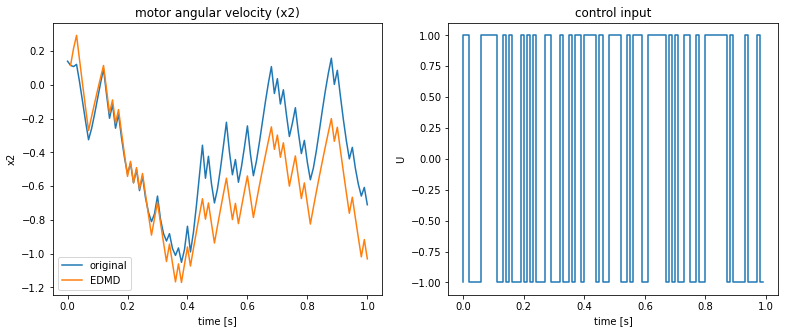

In [76]:
f, ax = plt.subplots(ncols=2, figsize=[13,5])
ax[0].set_title("motor angular velocity (x2)")
ax[0].set_ylabel("x2")
ax[0].set_xlabel("time [s]")
ax[0].plot(X_model_pred.time_values(), X_model_pred.loc[:, output].to_numpy(), label="original")
ax[0].plot(X_edmd_pred.time_values(), X_edmd_pred.loc[:, output].to_numpy(), label="EDMD")
ax[0].legend()

ax[1].set_title("control input")
ax[1].set_xlabel("time [s]")
ax[1].set_ylabel("U")
ax[1].step(U_test.time_values(), U_test.to_numpy())

### Koopman operator model predictive control setting

The goal is now to control the angular velocity reference of the original model. $y=x_2$, such that it follows a predefined reference trajectory. For this we set up a linear model predictive control on the intrinsic states of the EDMD model. This is reflected in the objective function minimized:

$$J = (Cz_{N_p} - y_r)^T Q_{N_p} (Cz_{N_p} - y_r) + \sum_{i=0}^{N_p-1} (Cz_{i} - y_r)^T Q (Cz_{i} - y_r) + u_i^T R u_i$$

Here $z$ are the intrinsic dictionary states of EDMD and $C=[1,0,\ldots, 0]$ is a projection of state $z$ onto the predicted output coordinate $x_2$. The cost terms within the optimization are  $Q = Q_{N_p} = 1$ and $R = 0.01$. The prediction horizon is set to one seconds, resulting in $N_p = 100$ timesteps ($\Delta t = 0.01$). 

In [77]:
mpc_horizon = 1
mpc_n_timesteps = int(np.round(mpc_horizon / dt))
Q = 1
R = 0.01

We can evaluate the performance of the  KMPC controller in two different scenarios (not both are computed; please select). In the first scenario, the output is constrained to $y_r(t) \in [-0.6, 0.6]$ and the objective is to track a piecewise constant function. In the second scenario, we will impose the constraint of $y \in [−0.4, 0.4]$ and track a time-varying reference of $y_r(t) = 0.5\cos(2\pi t/3)$, which may violate the output constraint during some part of the simulation period. The original paper shows that the controller based on local linearization fails for the second case.

In [89]:
MODE = ["step", "cos"][0] # select
time_horizon = 3  # simulation length of the reference trajectory
n_timesteps = time_horizon / dt

from scipy.interpolate import interp1d
    
if MODE == "step":
    ymin, ymax = -0.6, 0.6
    x0 = TSCDataFrame.from_array(np.array([[0, 0.6]]), feature_names=X_tsc.columns)
    step_function = interp1d([0, .5, 1.5, 2, 2.5], [-.3, .4, -.6, -.2, .2], kind="previous", fill_value="extrapolate")
    values = step_function(np.linspace(0, time_horizon, int(n_timesteps)))[:, np.newaxis]
    #values = (0.3 * (-1 + 2 * (np.arange(1, n_timesteps) > n_timesteps / 2)))[:, np.newaxis]
    reference = TSCDataFrame.from_array(values, time_values=np.arange(dt * 2, dt * (n_timesteps + 1), dt), feature_names=[output])
elif MODE == "cos":
    ymin, ymax = -0.4, 0.4
    x0 = TSCDataFrame.from_array(np.array([[-0.1, 0.1]]), feature_names=X_tsc.columns)
    values = (0.5 * np.cos(2 * np.pi * np.arange(1, n_timesteps) / n_timesteps)[:, np.newaxis]) 
    reference = TSCDataFrame.from_array(values, time_values=np.arange(dt * 2, dt * (n_timesteps + 1), dt), feature_names=[output])
else:
    raise RuntimeError("Mode not available")

ValueError: Shape of passed values is (300, 1), indices imply (299, 1)

In [90]:
n_timesteps

300.0

Set up the Koopman-operator-based model predictive control model. Afterwards set up data structures to store the control and controlled model output. The first element is the initial condition as specified above based on the scenario. 

In [79]:
kmpc = LinearKMPC(
    edmd=edmd,
    horizon=mpc_n_timesteps,
    input_bounds=np.array([[-1, 1]]),
    state_bounds=np.array([[ymin, ymax]]),
    qois=[output],
    cost_running=Q,
    cost_terminal=Q,
    cost_input=R,
)

U_seq = TSCDataFrame.from_array(
    np.zeros(edmd.n_samples_ic_ - 1), feature_names=U.columns
)
X_ic, _ = sys.predict_vectorize(x0, U=U_seq, dt=dt)
X_seq = pd.concat(
    [X_ic, shift_time_index_U(X_ic, U_seq)], axis=1
).fillna(0)

Perform the MPC loop. The numbers give references to the code in the next cell.

1. extract the relevant part of the reference time series over the current prediction time horizon (over which to optimize the control sequence)
2. if necessary, fill up the reference with the last state to obtain the required time series length
3. obtain optimal control sequence from KMPC
4. forward the true model with the next optimal control
5. augment the state for the next prediction
6. store the control input and state the sequence, which is used later for plotting

In [80]:
for i in tqdm(range(reference.shape[0]-1)):

    # 1.
    _ref = reference.iloc[i : i + mpc_n_timesteps, :]

    # 2. 
    if _ref.shape[0] != mpc_n_timesteps:
        _ref = _ref.tsc.fill_timeseries_with_last_state(n_timesteps=mpc_n_timesteps)

    # 3.
    ukmpc = kmpc.control_sequence(
        X=X_seq.iloc[-2:, :].loc[:, edmd.feature_names_in_], reference=_ref
    )

    next_control = ukmpc.iloc[[0], :]

    # 4. 
    state, _ = sys.predict_vectorize(
        X_seq.iloc[[-1], :].loc[:, ["x1", "x2"]],
        U=next_control,
        dt=dt
    )

    # 5. 
    new_state = pd.concat([state.iloc[[-1], :], shift_time_index_U(state, next_control)], axis=1)

    # 6. 
    U_seq = pd.concat([U_seq, next_control], axis=0)
    X_seq = pd.concat([X_seq, new_state], axis=0)


100%|█████████████████████████████████████████| 298/298 [00:55<00:00,  5.39it/s]


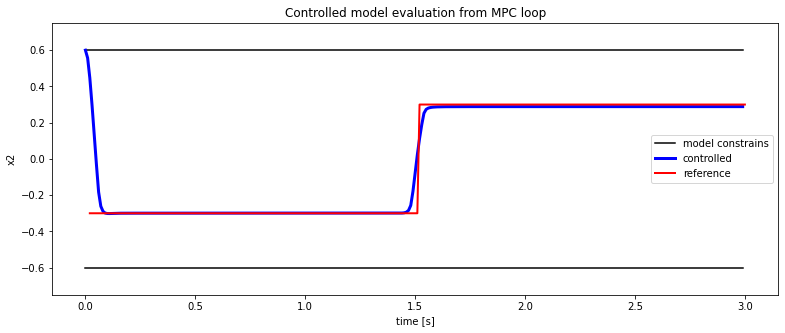

In [81]:
f, ax = plt.subplots(figsize=[13,5])
ax.set_title("Controlled model evaluation from MPC loop")
ax.set_xlabel("time [s]")
ax.set_ylabel("x2")
teval = X_seq.time_values()
ax.plot(teval, np.ones_like(teval) * ymin, c="black")
ax.plot(teval, np.ones_like(teval) * ymax, c="black", label="model constrains")
ax.plot(teval, X_seq.loc[:, "x2"].to_numpy(), c="blue", linewidth=3, label="controlled")
ax.plot(reference.time_values(), reference.to_numpy(), c="red", linewidth=2, label="reference")
ax.set_ylim([ymin-.15, ymax +.15])
ax.legend()

*Remark for the cosine setting:*

We see that the  KMPC accounts for the state constrains and does not leave the valid region. Within constrains the controlled system closely follows the reference trajectory.